In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
plt.figure(figsize=(10,10))

def get_img(path):
  test_img = Image.open(path)
  # test_img = test_img.resize((6, 6))
  plt.subplot(5,5,i)
  plt.imshow(test_img, cmap = "gray")
  test_img = test_img.convert('1')
  test_x = np.array(test_img, np.float32)
  test_x = test_x.reshape([-1, 36])
  return test_x

<Figure size 720x720 with 0 Axes>

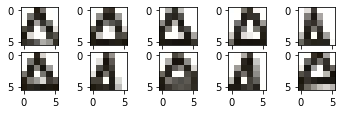

In [7]:
x_train = []
y_train = []
  
path = '/content/drive/My Drive/colab/lab2/Triangle/1_'
for i in range(1,11,1):
  x_train.append(get_img(path + str(i) +'.jpg')[0])
  y_train.append(1)

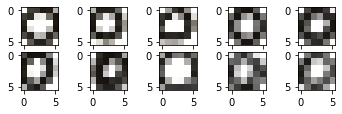

In [8]:
path = '/content/drive/My Drive/colab/lab2/Circle/2_'
for i in range(1,11,1):
  x_train.append(get_img(path + str(i) +'.jpg')[0])
  y_train.append(0)

In [9]:
print(x_train[0])

[1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.]


In [10]:
def fun_sigmoid(s):
  return 1 / (1 + np.exp(-s))

def fun_der_sigm(s):
  return fun_sigmoid(s) * (1 - fun_sigmoid(s))

def err_acc(pred_y, tst_y, eps):
  hit = 0
  for i in range(len(tst_y)):
    if(np.abs(pred_y[i] - tst_y[i]) < eps): hit = hit + 1
  return hit / len(tst_y)

def err_los(pred_y, tst_y):
  loss = 0
  for i in range(len(tst_y)):
    loss += np.square(pred_y[i] - tst_y[i])
  loss = np.sqrt(loss) / len(tst_y)
  return loss

class Neuron:
  def __init__(self, weightsCount, number = None):
    if number is None: 
      self.weights = []
      for i in range(weightsCount):
        self.weights.append(np.random.normal() * 3)
      self.bias = np.random.normal() * 3
    else:
      self.weights = [] 
      for i in range(weightsCount):
        self.weights.append(number)
      self.bias = number

  def get_sum(self, x):
    sum = self.bias
    for i in range(len(self.weights)):
      sum += self.weights[i] * x[i]
    return sum

  def feed(self, x):
    y = fun_sigmoid(self.get_sum(x))
    return y

  def print_params(self):
    n_str = ''
    for i in range(len(self.weights)):
      n_str += str(self.weights[i]) + " "
    print(n_str + str(self.bias))

  def change_weights(self, value, x):
    for i in range(len(self.weights)):
      if(x[i] == 1):
        self.weights[i] += value
    self.bias += value

class Network:
  def __init__(self, x_count):
    self.NeuronsL1 = []
    self.NeuronsL2 = []
    self.NeuronsL3 = Neuron(12)
    for i in range(25):
      n = Neuron(x_count)
      self.NeuronsL1.append(n)
    for i in range(12):
      n = Neuron(25)
      self.NeuronsL2.append(n)

  def predict(self, data):
    y_pred = []
    for x in data:
      res1 = []
      for n in self.NeuronsL1:
        res1.append(n.feed(x))
      res2 = []
      for n in self.NeuronsL2:
        res2.append(n.feed(res1))
      y_pred.append(self.NeuronsL3.feed(res2))
    return y_pred

  def trainGrad(self, data, y_trues, speed, epochs):
    errs = []
    epchs = []
    for epoch in range(epochs):
      for x, y_true in zip(data, y_trues):
        self.grad_iteration(x, y_true, speed)
      if epoch % (epochs // 10) == 0:
        y_preds = self.predict(data)
        err = err_los(y_trues, y_preds)
        acc = err_acc(y_trues, y_preds, 0.1)
        epchs.append(epoch)
        errs.append(err)
        print("Epoch %d err: %.3f" % (epoch, err))
        print("Epoch %d acc: %.3f" % (epoch, acc))
    return epchs, errs

  def trainGradStochastic(self, data, y_trues, speed, epochs):
    errs = []
    epchs = []
    for epoch in range(epochs):
      n_rule = np.random.randint(0, len(data))
      x = data[n_rule]
      y_true = y_trues[n_rule]
      self.grad_iteration(x, y_true, speed)
      if epoch % (epochs // 10) == 0:
        y_preds = self.predict(data)
        err = err_los(y_trues, y_preds)
        epchs.append(epoch)
        errs.append(err)
        acc = err_acc(y_trues, y_preds, 0.1)
        print("Epoch %d err: %.3f" % (epoch, err))
        print("Epoch %d acc: %.3f" % (epoch, acc))
    return epchs, errs

  def grad_iteration(self, x, y_true, speed):
    res1 = []
    for n in self.NeuronsL1:
      res1.append(n.feed(x))
    res2 = []
    for n in self.NeuronsL2:
      res2.append(n.feed(res1))
    out1 = self.NeuronsL3.feed(res2)
    # Изменение весов на выходном слое
    delta = out1 - y_true
    grad = delta * fun_der_sigm(out1)
    for i in range(len(res2)):
      self.NeuronsL3.weights[i] = self.NeuronsL3.weights[i] - speed * grad * res2[i]
    self.NeuronsL3.bias = self.NeuronsL3.bias - speed * grad * 1
    # Изменение весов на втором слое 
    grad2 = []
    for i in range(len(res2)):
      grad2.append(grad * self.NeuronsL3.weights[i] * fun_der_sigm(res2[i]))
    grad2_bias = grad * self.NeuronsL3.bias * fun_der_sigm(res2[i])
    for i in range(len(self.NeuronsL2)):
      for j in range(len(res1)):
        self.NeuronsL2[i].weights[j] = self.NeuronsL2[i].weights[j] - speed * grad2[i] * res1[j]
      self.NeuronsL2[i].bias = self.NeuronsL2[i].bias - speed * grad2_bias * 1
    # Изменение весов на первом слое
    grad3 = []
    for i in range(len(res1)):
      grad_sum = 0
      for j in range(len(self.NeuronsL2)):
        grad_sum += grad2[j] * self.NeuronsL2[j].weights[i] * fun_der_sigm(res1[i])
      grad3.append(grad_sum)
    grad3_bias = 0
    for j in range(len(self.NeuronsL2)):
      grad3_bias += grad2[j] * self.NeuronsL2[j].bias * fun_der_sigm(1)
    for i in range(len(self.NeuronsL1)):
      for j in range(len(x)):
        self.NeuronsL1[i].weights[j] = self.NeuronsL1[i].weights[j] - speed * grad3[i] * x[j]
      self.NeuronsL1[i].bias = self.NeuronsL1[i].bias - speed * grad3_bias * 1

In [11]:
network = Network(36)

epochs, errors = network.trainGrad(x_train, y_train,0.5, 150)

Epoch 0 err: 0.116
Epoch 0 acc: 0.400
Epoch 15 err: 0.011
Epoch 15 acc: 0.900
Epoch 30 err: 0.003
Epoch 30 acc: 1.000
Epoch 45 err: 0.002
Epoch 45 acc: 1.000
Epoch 60 err: 0.001
Epoch 60 acc: 1.000
Epoch 75 err: 0.001
Epoch 75 acc: 1.000
Epoch 90 err: 0.001
Epoch 90 acc: 1.000
Epoch 105 err: 0.001
Epoch 105 acc: 1.000
Epoch 120 err: 0.001
Epoch 120 acc: 1.000
Epoch 135 err: 0.001
Epoch 135 acc: 1.000


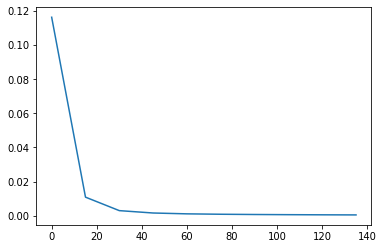

In [12]:
plt.plot(epochs, errors)
plt.show()

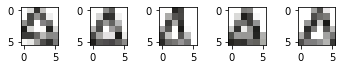

In [13]:
x_test_big = []
x_test = []
y_test = []
path = '/content/drive/My Drive/colab/lab2/TestTriangle/3_'
for i in range(1,6,1):
  x_test.append(get_img(path + str(i) +'.jpg')[0])
  y_test.append(1)

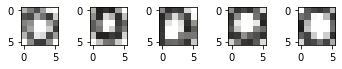

In [14]:
path = '/content/drive/My Drive/colab/lab2/TestCircle/4_'
for i in range(1,6,1):
  x_test.append(get_img(path + str(i) +'.jpg')[0])
  y_test.append(0)

In [15]:
def get_res(y):
  if y > 0.5:
    return 1
  return 0

In [ ]:
y_pred = network.predict(x_test)
y_pred_binary = []
for i in range(len(y_pred)):
  y_pred_binary.append(get_res(y_pred[i])) 
acc = err_acc(y_test, y_pred_binary, 0.1)
print("acc:" + str(acc))
ress = ['Окружность', 'Треугольник']
plt.figure(figsize=(15,5))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.title(ress[get_res(y_pred[i])])
  img = np.reshape((x_test[i]), [6, 6])
  plt.imshow(img, cmap="gray")

In [ ]:
print(y_pred)
print(y_pred_binary)